In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/flatiron-capstone-project/submission.csv
/kaggle/input/flatiron-capstone-project/train_df.csv
/kaggle/input/flatiron-capstone-project/preprocessed_df.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/test/8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2100032a-7c33-4bff-97ef-690822c43466.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2f392438-e215-4169-bebf-21ac4ff253e1.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/3f316b38-1a24-45a9-8d8c-4e05a42257c6.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/f8b03c87-9d1a-4f20-b76b-cb6c69d447b2.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/585ba241-6348-41ce-a5d2-c9ee434cd64d.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/

# Libraries

In [2]:
import pandas as pd
import numpy as np
import random
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import re
import json
from tqdm.autonotebook import tqdm
import string
import itertools

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import utils
from keras.models import *
from keras.layers import *
from keras.callbacks import *

from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [3]:
#define stopwords
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

In [4]:
#add callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

#define the callbacks
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1),
                 ModelCheckpoint(filepath = 'cnn_model.h5', monitor = 'val_loss', save_best_only = True)]

# OBTAIN

In [5]:
#read train data
train_df = pd.read_csv('../input/flatiron-capstone-project/train_df.csv', index_col = 0)
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this study used data from the national educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,stress satisfactory outcomes for all youth inc...
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,federal reserve bank of richmond s1 accounting...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this article investigates an important factor ...


In [6]:
#read submission data
submission_df = pd.read_csv('../input/flatiron-capstone-project/submission.csv', index_col = 0)
submission_df.head()

,Id,PredictionString,text
0,2100032a-7c33-4bff-97ef-690822c43466,NaN,Cognitive deficits and reduced educational ach...
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN,This report describes how the education system...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN,"Cape Hatteras National Seashore (CAHA), locate..."
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN,A significant body of research has been conduc...


Now, our job is to fill in the column 'PredictionString' with cleaned_label that matches the given text.

# PREPROCESSING

### Train-Test-Split

In [7]:
X = train_df['dataset_title'].to_numpy()
y = train_df['cleaned_label'].to_numpy()

#split traing data into training a validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [8]:
#check shape
print('Train sentences:', X_train.shape, '\n', 
      'Test sentences:', X_test.shape, '\n', 
      'Train labels:', y_train.shape, '\n', 
      'Test labels:', y_test.shape)

Train sentences: (15728,) 
 Test sentences: (3933,) 
 Train labels: (15728,) 
 Test labels: (3933,)


In [9]:
# find avg # of takens (words) in the training set
round(sum([len(i.split()) for i in X_train]) / len(X_train))

5

### Vectorize

In [10]:
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 5 #max length our sequences will be 

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length)

#fit the text vectorizer to dataset, .adapt method sets the layer's vocabulary
text_vectorizer.adapt(X_train)
text_vectorizer.adapt(X_test)

### Tokenize

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#vectorization parameters
#limit on the number of features. We use the top 20K features.
top_k = 20000

#limit on the length of text sequences. Sequences longer than this will be truncated.
max_sequence_length = 500

#method to count the unique words in vocabulary and assign each of those words to indices
tokenizer = Tokenizer(num_words = top_k)

#create vocabulary with training texts
tokenizer.fit_on_texts(list(X_train))

#convert text into integer sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

#het max sequence length.
max_length = len(max(X_train, key = len))
if max_length > max_sequence_length:
    max_length = max_sequence_length
        
        
#fix sequence length to max value. Sequences shorter than the length are
#padded in the beginning and sequences longer are truncated at the beginning.
X_train_pad  = pad_sequences(X_train_seq, maxlen = max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen = max_sequence_length)

In [12]:
#number of unique words in the training data
size_of_vocabulary = len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

154


In [13]:
word_index = tokenizer.word_index
word_index

{'disease': 1,
 "alzheimer's": 2,
 'neuroimaging': 3,
 'initiative': 4,
 'adni': 5,
 'study': 6,
 'longitudinal': 7,
 'of': 8,
 'survey': 9,
 'and': 10,
 'international': 11,
 'aging': 12,
 'baltimore': 13,
 'blsa': 14,
 'in': 15,
 'education': 16,
 'science': 17,
 'trends': 18,
 'mathematics': 19,
 'early': 20,
 'childhood': 21,
 'sars': 22,
 'cov': 23,
 '2': 24,
 'genome': 25,
 'sequence': 26,
 'national': 27,
 'census': 28,
 'agriculture': 29,
 '19': 30,
 'data': 31,
 'agricultural': 32,
 'resource': 33,
 'management': 34,
 'sea': 35,
 'north': 36,
 'american': 37,
 'breeding': 38,
 'bird': 39,
 'bbs': 40,
 'world': 41,
 'earned': 42,
 'doctorates': 43,
 'rural': 44,
 'urban': 45,
 'continuum': 46,
 'codes': 47,
 'covid': 48,
 'beginning': 49,
 'postsecondary': 50,
 'student': 51,
 'for': 52,
 'noaa': 53,
 'tide': 54,
 'gauge': 55,
 'dataset': 56,
 'best': 57,
 'track': 58,
 'archive': 59,
 'climate': 60,
 'stewardship': 61,
 'program': 62,
 'common': 63,
 'core': 64,
 'research': 6

### Encode Label

In [14]:
from sklearn import preprocessing

#use the LabelEncoder to convert text labels to integers, 0, 1, 2, etc.
encoder = preprocessing.LabelEncoder()

#since we have two different data set (X_train and X_test), 
#we need to fit it on all of our data otherwise there might be some categories in the test set X_test that were not in the train set X_train 
#and we will get errors
encoder.fit(list(y_train) + list(y_test)) 
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

### Binarize Label

In [15]:
from keras import utils

#binarize the labels for the neural net
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [16]:
print('X_train shape:', X_train_pad.shape)
print('X_test shape:', X_test_pad.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (15728, 500)
X_test shape: (3933, 500)
y_train shape: (15728, 130)
y_test shape: (3933, 130)


### Load Pretrained Word Vector

In [17]:
#load the whole embedding into memory
embeddings_index = {}
f = open('../input/glove840b300dtxt/glove.840B.300d.txt')

for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = coefs
    except ValueError: #catch the exception where there are strings in the GloVe text file, can be avoided if use glove.42B.300d.txt
        pass
    
f.close()

print('Found %s word vectors.' % len(embeddings_index))

0it [00:00, ?it/s]

Found 2195885 word vectors.


In [18]:
#create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

  0%|          | 0/153 [00:00<?, ?it/s]

### Other Aux Functions

In [19]:
#from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    #compute confusion matrix
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90, fontsize = 12)
    plt.yticks(tick_marks, classes, fontsize = 12)

    #loop over data dimensions and create text annotations
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label', fontsize = 25)
    plt.xlabel('Predicted label', fontsize = 25)
    plt.tight_layout()

# MODELING

Original model function can be found at: https://developers.google.com/machine-learning/guides/text-classification/step-4

When there are more than 2 classes (multi-class classification), our model should output one probability score per class. The sum of these scores should be 1. 

## The Last Layer

In [20]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

# sepcnn_model

The following code constructs a four-layer sepCNN model.

In [21]:
def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding = True,
                 is_embedding_trainable = False,
                 embedding_matrix = embedding_matrix):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [22]:
sepcnn_model = sepcnn_model(3,             #blocks
                            3,             #filer
                            32,            #kernel_size
                            300,           #embedding_dim
                            0.3,           #dropout_rate
                            2,             #pool_size
                            (15728, 500),  #input_shape
                            130,           #num_classes
                            size_of_vocabulary,
                            use_pretrained_embedding = True,
                            is_embedding_trainable = False,
                            embedding_matrix = embedding_matrix)

In [23]:
#summary
sepcnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15728, 300)        46200     
_________________________________________________________________
dropout (Dropout)            (None, 15728, 300)        0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 15728, 3)          10503     
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 15728, 3)          108       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7864, 3)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7864, 3)           0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 7864, 3)           1

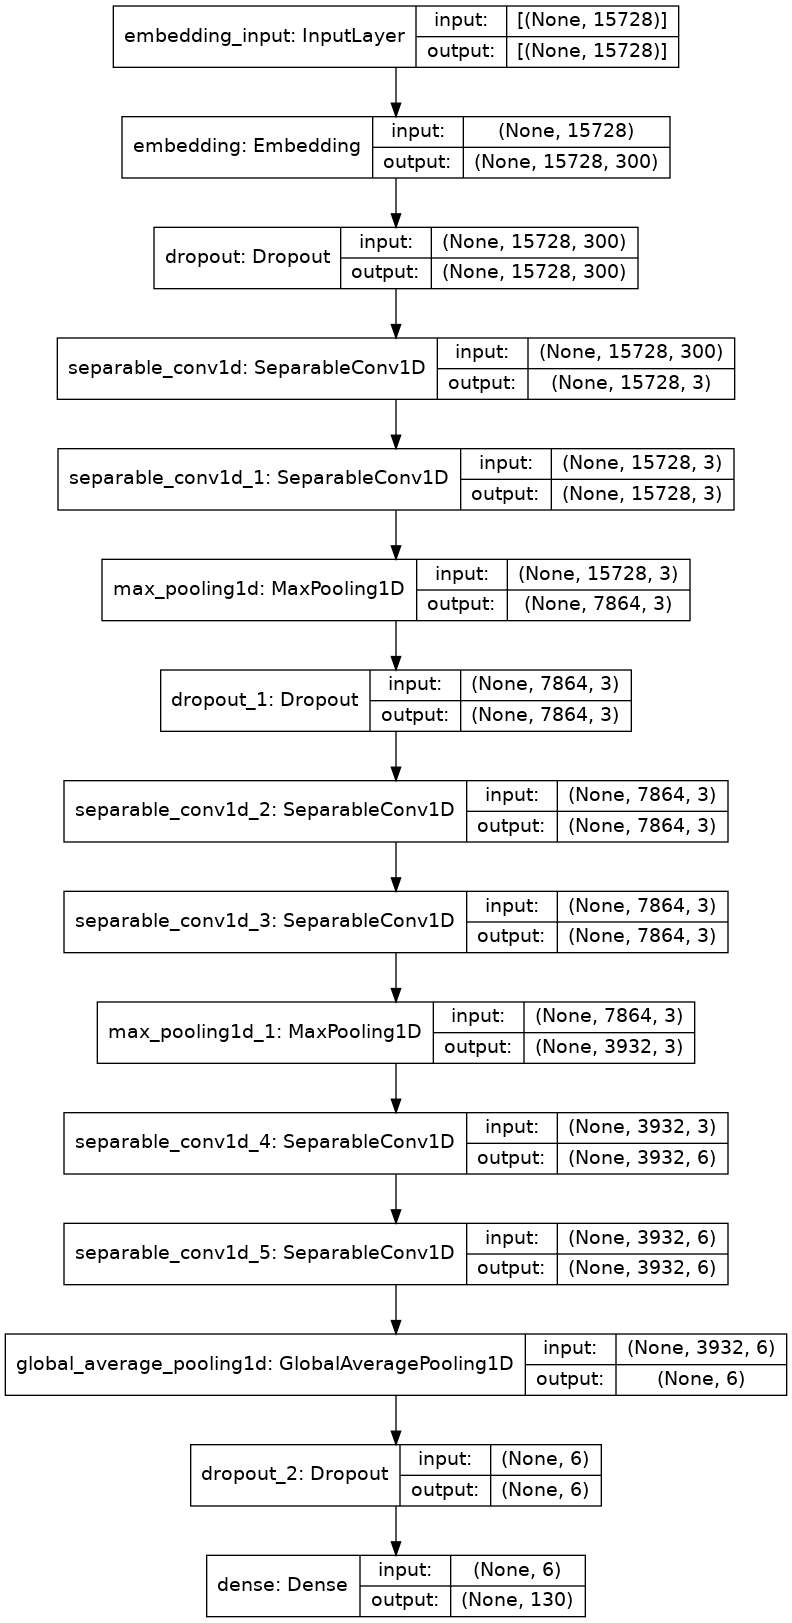

In [24]:
#plot
plot_model(sepcnn_model, to_file = 'sepcnn_model_plot.png', show_shapes = True, show_layer_names = True)

In [25]:
#compile
sepcnn_model.compile(optimizer = keras.optimizers.Adam(0.0001), #low learning rate is good, but the model will take more iterations to converge
                    loss = 'categorical_crossentropy',
                    metrics = ['acc'])

In [26]:
from sklearn.utils import class_weight

#correct class imbalance
class_weights = list(class_weight.compute_class_weight('balanced',
                                                       np.unique(train_df['cleaned_label']),
                                                       train_df['cleaned_label']))

weights = {}
for index, weight in enumerate(class_weights) : weights[index] = weight

In [27]:
start = datetime.datetime.now()

#fit
sepcnn_history = sepcnn_model.fit(np.array(X_train_pad), np.array(y_train),
                                  #class_weight = weights,
                                  batch_size = 32,
                                  epochs = 100,
                                  verbose = 1,
                                  validation_data = (np.array(X_test_pad), np.array(y_test)),
                                  callbacks = early_stopping)

Epoch 1/100
492/492 [==============================] - 112s 224ms/step - loss: 4.8337 - acc: 0.0309 - val_loss: 4.1425 - val_acc: 0.0120
Epoch 2/100
492/492 [==============================] - 109s 222ms/step - loss: 4.1100 - acc: 0.0959 - val_loss: 3.4698 - val_acc: 0.1238
Epoch 3/100
492/492 [==============================] - 109s 221ms/step - loss: 3.6257 - acc: 0.1234 - val_loss: 3.1234 - val_acc: 0.1238
Epoch 4/100
492/492 [==============================] - 108s 220ms/step - loss: 3.4326 - acc: 0.1361 - val_loss: 3.0367 - val_acc: 0.1803
Epoch 5/100
492/492 [==============================] - 109s 221ms/step - loss: 3.3171 - acc: 0.1445 - val_loss: 2.9626 - val_acc: 0.1803
Epoch 6/100
492/492 [==============================] - 109s 221ms/step - loss: 3.1827 - acc: 0.1543 - val_loss: 2.8921 - val_acc: 0.1803
Epoch 7/100
492/492 [==============================] - 108s 220ms/step - loss: 3.0856 - acc: 0.1560 - val_loss: 2.8362 - val_acc: 0.1803
Epoch 8/100
492/492 [====================

In [28]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 2:35:55.955021


In [29]:
#save model
sepcnn_model.save('sepcnn_model.h5')

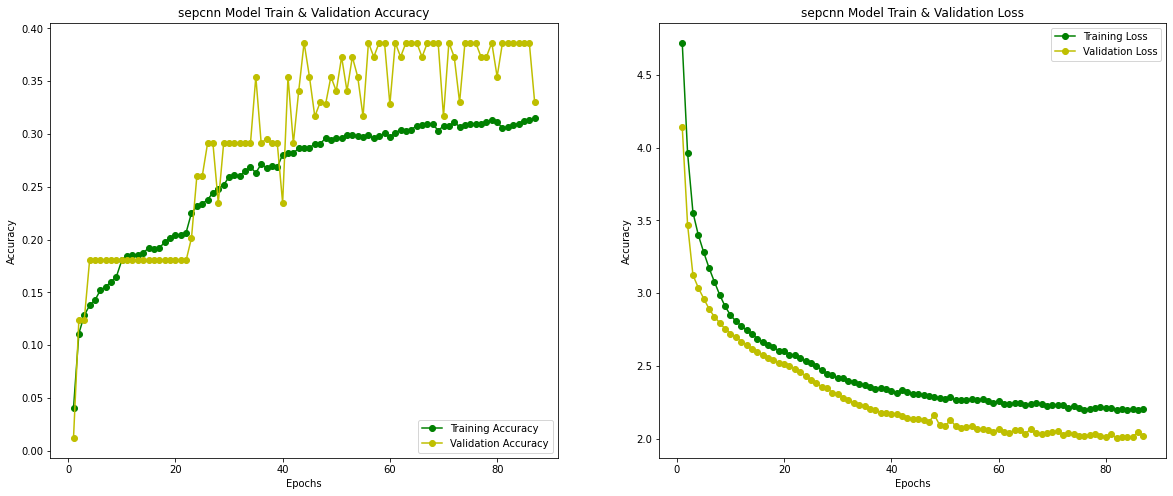

In [30]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

sepcnn_train_acc = sepcnn_history.history['acc']
sepcnn_train_loss = sepcnn_history.history['loss']
sepcnn_val_acc = sepcnn_history.history['val_acc']
sepcnn_val_loss = sepcnn_history.history['val_loss']

epochs = range(1, len(sepcnn_train_acc) + 1)

ax[0].plot(epochs , sepcnn_train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , sepcnn_val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('sepcnn Model Train & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, sepcnn_train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs, sepcnn_val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('sepcnn Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

plt.show()

In [31]:
#save
plt.savefig('sepcnn_acc_loss.png')

<Figure size 432x288 with 0 Axes>

In [32]:
#make prediction
sepcnn_yhat_test = sepcnn_model.predict(X_test_pad)

#to evaluate accuracy we need a vector of labels
sepcnn_yhat_test = np.argmax(sepcnn_yhat_test, axis = 1)
sepcnn_y_test = np.argmax(y_test, axis = 1)

#get classification report
print('Model: sepcnn', '\n', classification_report(sepcnn_y_test, sepcnn_yhat_test))

Model: sepcnn 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00       709
           4       0.00      0.00      0.00         2
           8       0.46      1.00      0.63       127
           9       0.00      0.00      0.00         8
          10       0.40      1.00      0.57       487
          11       0.00      0.00      0.00        17
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00        45
          16       0.00      0.00      0.00        21
          17       0.37      1.00      0.54       248
          18       0.00      0.00      0.00        86
          19       0.00      0.00      0.00        13
          20       0.00      0.00      0.00        47
          21       0.00      0.00      0.00        39
          2

In [33]:
#generate a prediction on individual examples
sepcnn_text_labels = encoder.classes_ 

for i in range(10):
    prediction = sepcnn_model.predict(np.array([X_test_pad[i]]))
    predicted_label = sepcnn_text_labels[np.argmax(prediction)]
    print(train_df['dataset_title'].iloc[i][:50], '...')
    print('Actual label: ' + train_df['cleaned_label'].iloc[i])
    print('Predicted label: ' + predicted_label + '\n')

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: baltimore longitudinal study of aging

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: alzheimer s disease neuroimaging initiative adni 

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: survey of earned doctorates

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: trends in international mathematics and science study

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: agricultural resource management survey

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: alzheimer s disease neuroimaging initiative adni 

National Education Longitudinal Study ...
Actual label: national edu

In [34]:
y_softmax = sepcnn_model.predict(X_test_pad)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

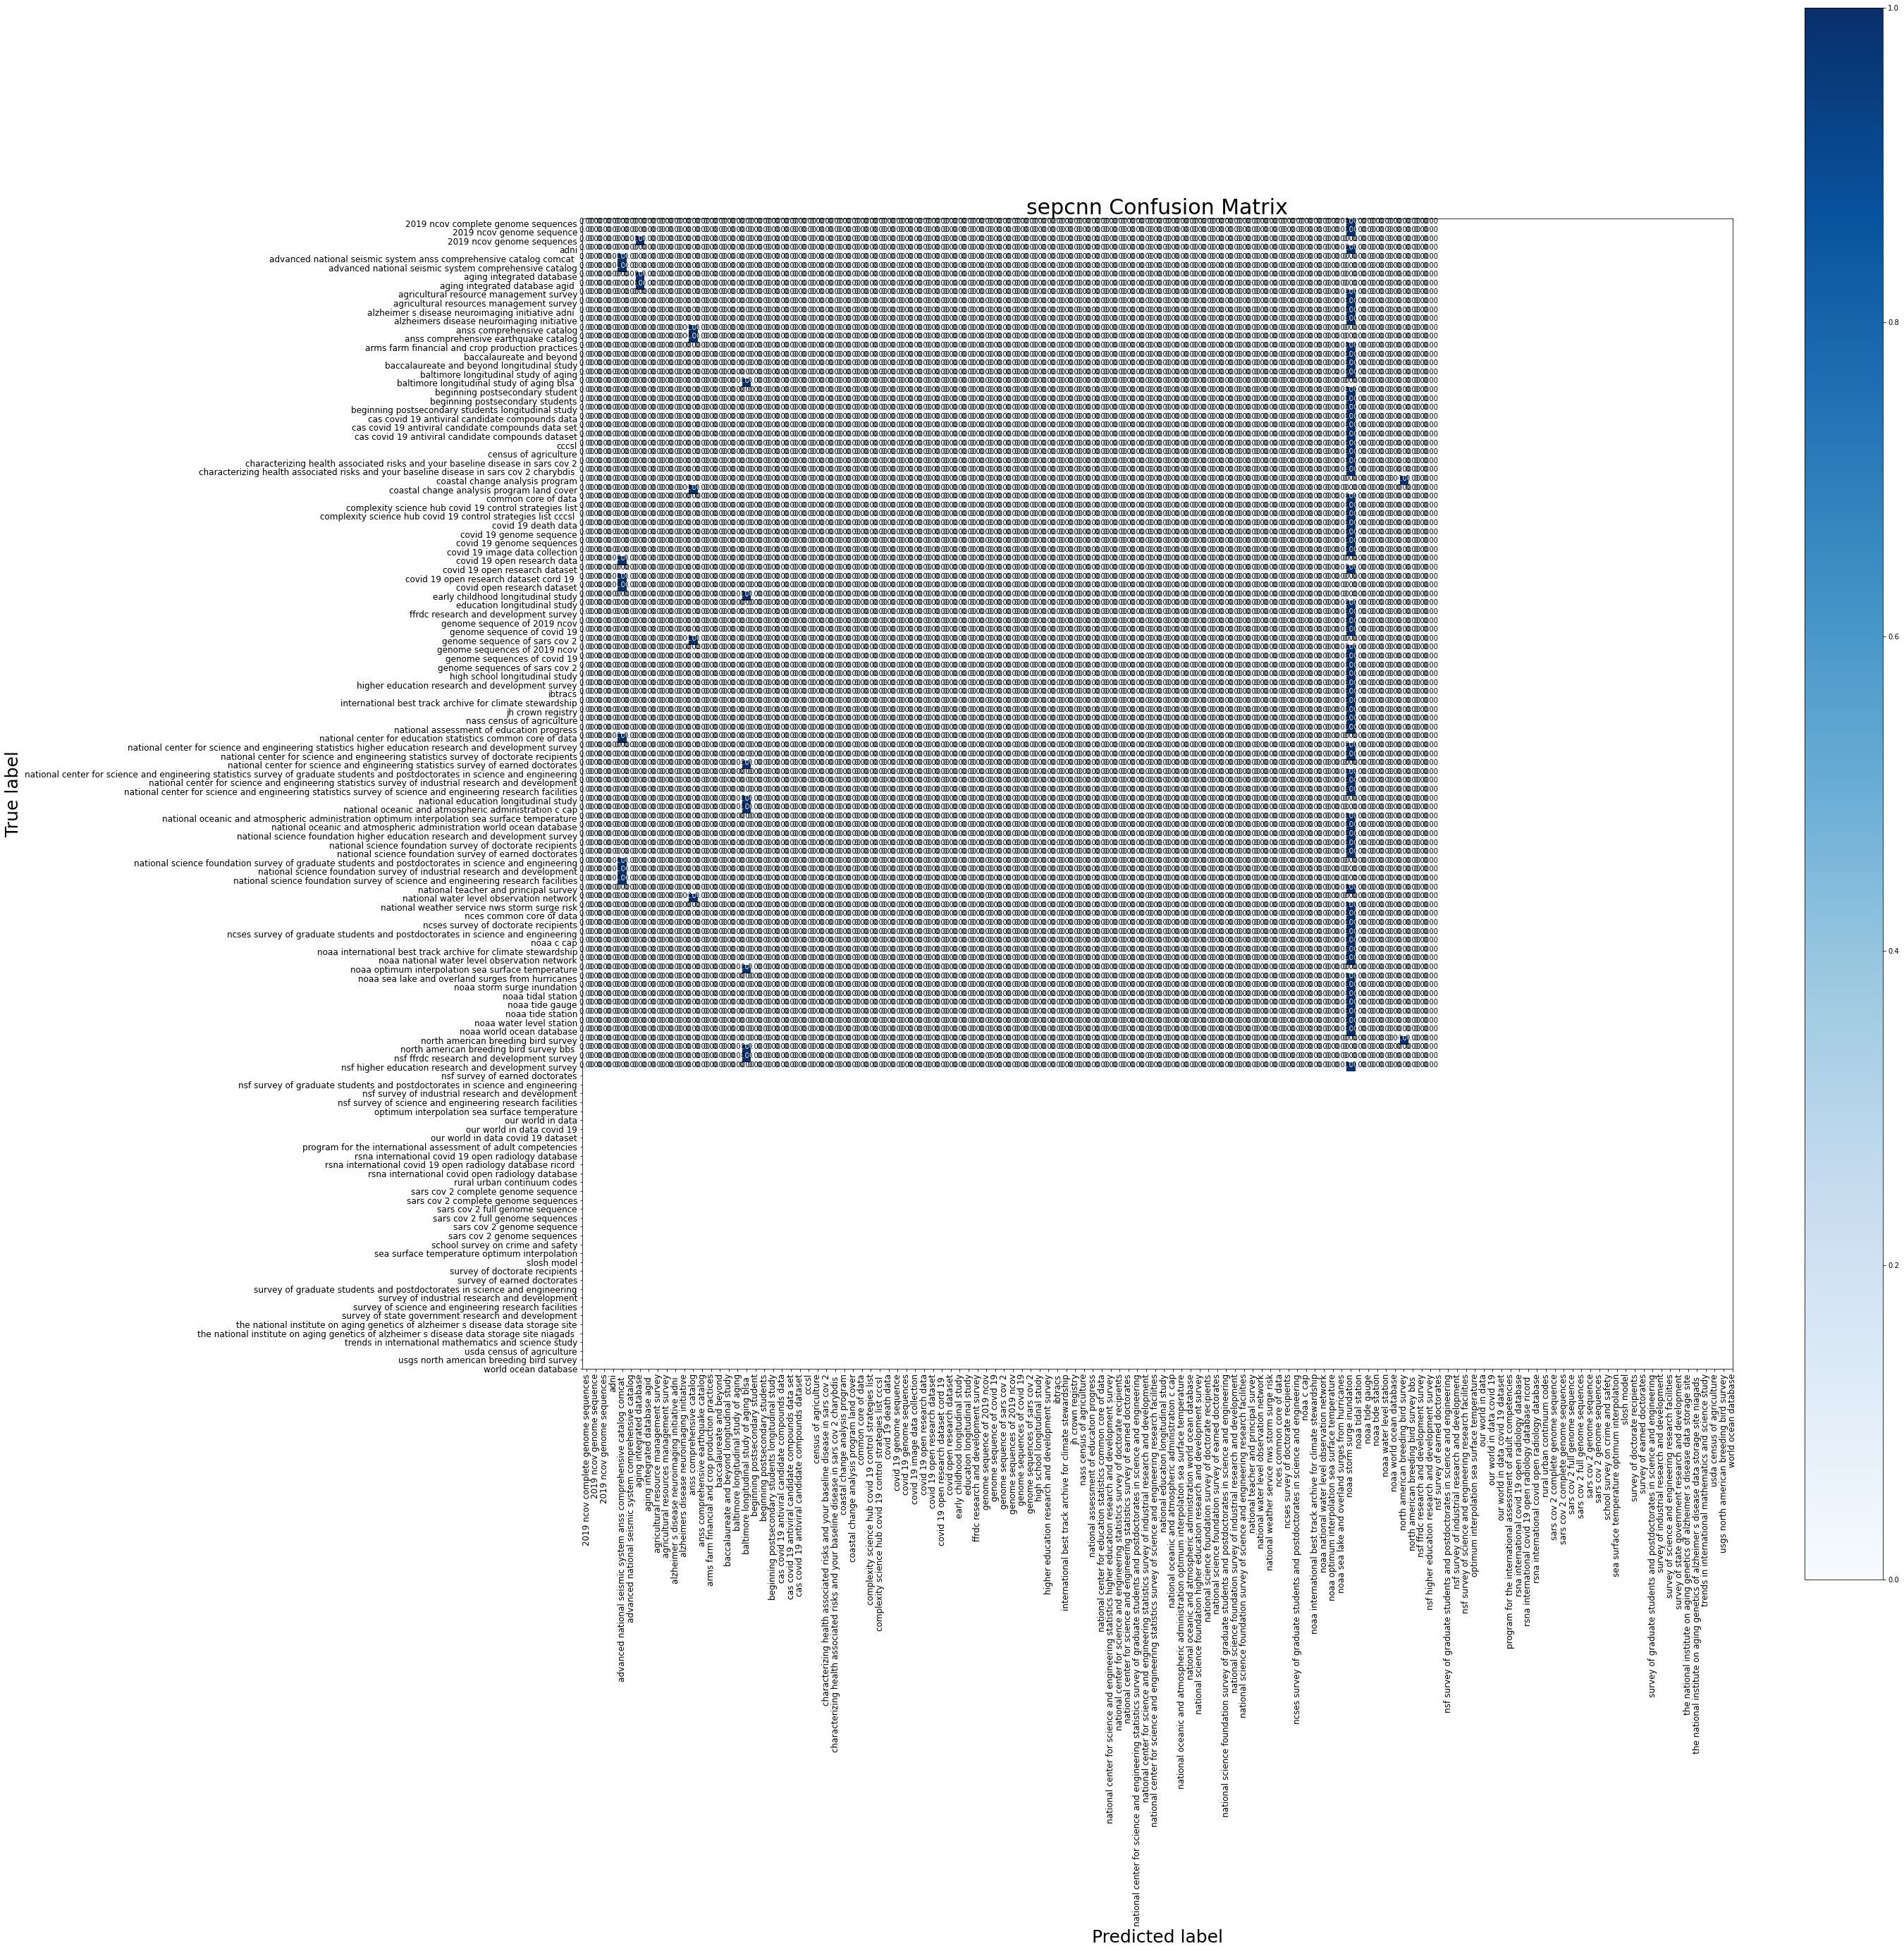

<Figure size 432x288 with 0 Axes>

In [35]:
#get confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize = (40, 40))
plot_confusion_matrix(cm, classes = sepcnn_text_labels, title = 'sepcnn Confusion Matrix')
plt.show()

#save
plt.savefig('sepcnn_cm.png')

In [36]:
#summary table
summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [],
                              'Precision': [], 'Recall': [], 'F1': []})

In [37]:
#update summary table
summary_table.loc[0] = ['DL sepcnn',
                        round(accuracy_score(sepcnn_y_test, sepcnn_yhat_test), 2),
                        round(precision_score(sepcnn_y_test, sepcnn_yhat_test, average = 'macro'), 2), 
                        round(recall_score(sepcnn_y_test, sepcnn_yhat_test, average = 'macro'), 2), 
                        round(f1_score(sepcnn_y_test, sepcnn_yhat_test, average = 'macro'), 2)]
summary_table.head()

,Model,Accuracy,Precision,Recall,F1
0,DL sepcnn,0.33,0.02,0.06,0.03


# INTERPRETATION